In [1]:
import pandas as pd
import numpy as np
import cv2
from zipfile import ZipFile
import matplotlib.pyplot as plt
import sklearn.preprocessing
import os
import glob
import fnmatch
import scipy

In [2]:
base_file_name = "../input/bdrw/BDRW_train/BDRW_train_"
  
for i in range(2):
    with ZipFile(base_file_name+str(i+1)+'.zip', 'r') as zip: 
        print('Extracting all the files now...') 
        zip.extractall() 
        print('Done!') 

Extracting all the files now...
Done!
Extracting all the files now...
Done!


In [3]:
labels = pd.read_excel('BDRW_train_2/labels.xls', header=None, names=['digit_name', 'label'])
labels.head(10)

,digit_name,label
0,digit_0,1
1,digit_1,4
2,digit_2,2
3,digit_3,3
4,digit_4,1
5,digit_5,2
6,digit_6,3
7,digit_7,4
8,digit_8,5
9,digit_9,6


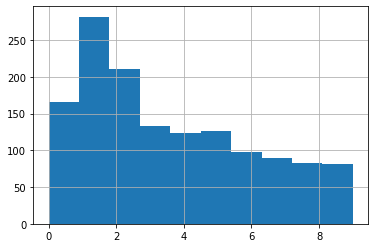

In [4]:
labels['label'].hist()
labels = np.array(labels['label'])

In [5]:
image_list = []
for i in range(2):
    for file in sorted(glob.glob('BDRW_train_'+str(i+1)+'/*.jpg'), key=lambda s:int(s.split('_')[-1].split('.')[0])):
        im = cv2.imread(file)
        image_list.append(im)
        
image_list = np.array(image_list)

array([35.45441493, 27.82483848])

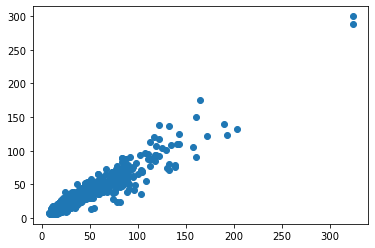

In [6]:
shapes = np.array([x.shape for x in image_list]).T
plt.scatter(shapes[0], shapes[1])
np.mean(shapes[:2], axis=1)

In [7]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image

In [8]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.85
X_train, X_test, Y_train, Y_test = train_test_split(image_list, labels, train_size=TRAIN_SIZE)

In [9]:
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, image_list, labels, height, width):
        self.image_list = image_list
        self.labels = labels
        self.height = height
        self.width = width
        
    def transform(self):
        return(transforms.Compose([
            transforms.Resize(size=(self.height, self.width)),
            transforms.ToTensor()
        ]))
    
    def __getitem__(self, index):
        label = self.labels[index]
        im = self.image_list[index]
        im = Image.fromarray(im)
        im = self.transform()(im)
        
        return (im, label)
    
    def __len__(self):
        return len(self.image_list)

In [10]:
HEIGHT = 35
WIDTH = 28
BATCH_SIZE = 64

train_ds = custom_dataset(X_train, Y_train, HEIGHT, WIDTH)
test_ds = custom_dataset(X_test, Y_test, HEIGHT, WIDTH)
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
class conv(nn.Module):
    def __init__(self, num_classes=10):
        super(conv, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(4*4*64, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

In [12]:
if torch.cuda.is_available():
    print("GPU is available!!!")
    device = torch.device('cuda:0')
else:
    print("GPU is not available ;-;")
    device = torch.device('cpu')

GPU is not available ;-;


In [13]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

def train():
    model = conv().to(device)
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    
    train_loss = []
    train_acc = []
    
    total_step = len(train_loader)
    for epoch in range(NUM_EPOCHS):
        
        running_loss = 0.0
        running_acc = 0.0
        tot = 0
        for i, (im, label) in enumerate(train_loader):
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            loss = criterion(out, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(out.data, 1)
            tot += preds.size(0)
            running_acc += torch.sum(preds==label).item()
            
        epoch_loss = running_loss/(i+1)
        epoch_acc = running_acc/(tot)
        
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f} %'
                    .format(epoch+1, NUM_EPOCHS, epoch_loss, epoch_acc*100))
    
    return model, train_loss, train_acc


def evaluate(model):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for (im, label) in test_loader:
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            _, preds = torch.max(out.data, 1)
            total += label.size(0)
            correct += (preds==label).sum().item()
            
        print('Test Accuracy : {} %'.format(100*correct/total))
        

In [14]:
model, train_loss, train_acc = train()

conv(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.4, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.4, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out

In [15]:
evaluate(model)

Test Accuracy : 93.77990430622009 %


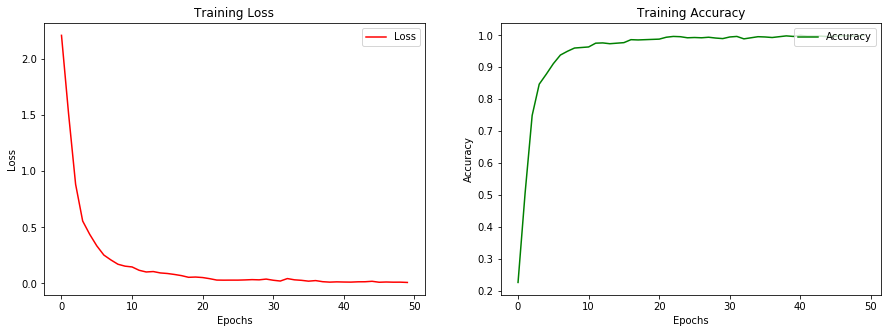

In [16]:
fig = plt.figure(figsize=[15, 5])

plt.subplot(121)
plt.plot(range(NUM_EPOCHS), train_loss, 'r-', label='Loss')
plt.gca().set_title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(122)
plt.plot(range(NUM_EPOCHS), train_acc, 'g-', label='Accuracy')
plt.gca().set_title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')